In [48]:
"""Define circuits to test"""
lambda_list = []
from supermarq.benchmarks import *
from supermarq.features import cirq_to_qiskit

# Random
# from qiskit.circuit.random import random_circuit
# random_lambda = lambda q: random_circuit(num_qubits=q, depth=q, measure=False, max_operands=2)
# lambda_list.append(random_lambda)

# # Quantum Volume
from qiskit.circuit.library import QuantumVolume
qv_lambda = lambda q: QuantumVolume(num_qubits=q, depth=q)
lambda_list.append(qv_lambda)

# QFT
from qiskit.circuit.library.basis_change import QFT
qft_lambda = lambda q: QFT(q)
lambda_list.append(qft_lambda)

# # Inverse QFT
# inverse_qft_lambda = lambda q: QFT(q, inverse=True)
# label = "IQFT"
# circuits[label] = CircuitTranspilerBenchmark(inverse_qft_lambda, q_range, label=label)

# QAOA, takes a long time to generate - consider capping max size before 20
# qaoa_lambda = lambda q: cirq_to_qiskit(QAOAFermionicSwapProxy(q).circuit())
# label = "QAOA_Fermionic_Swap"
# circuits[label] = CircuitTranspilerBenchmark(qaoa_lambda, q_range, label=label)

# # QAOA vanilla
qaoa_vanilla_lambda = lambda q: cirq_to_qiskit(QAOAVanillaProxy(q).circuit())
lambda_list.append(qaoa_vanilla_lambda)

# VQE - very slow to generate
# vqe_lambda = lambda q: cirq_to_qiskit(VQEProxy(q, 4).circuit()[0])
# label = "VQE"
# circuits[label] = CircuitTranspilerBenchmark(vqe_lambda, q_range, label=label)

# Simulation
hamiltonian_lambda = lambda q: cirq_to_qiskit(
    HamiltonianSimulation(q, 1 / 10, 0.5).circuit()
)
lambda_list.append(hamiltonian_lambda)

# weighted adder or ripple carry adder
from qiskit.circuit.library.arithmetic.adders.cdkm_ripple_carry_adder import (
    CDKMRippleCarryAdder,
)
from qiskit import QuantumCircuit

# using trick of composing into an empty circuit so that it builds everything into a single quantumregister
adder_lambda = (
    lambda q: QuantumCircuit(q)
    .compose(CDKMRippleCarryAdder(num_state_qubits=int((q - 1) / 2)), inplace=False)
    .decompose()
    .decompose()
    .decompose()
)
lambda_list.append(adder_lambda)


# multiplier
from qiskit.circuit.library.arithmetic.multipliers import RGQFTMultiplier
multiplier_lambda = (
    lambda q: QuantumCircuit(q)
    .compose(RGQFTMultiplier(num_state_qubits=int(q / 4)), inplace=False)
    .decompose()
    .decompose()
    .decompose()
)
lambda_list.append(multiplier_lambda)


# # GHZ
ghz_lambda = lambda q: cirq_to_qiskit(GHZ(q).circuit())
lambda_list.append(ghz_lambda)

In [49]:
import weylchamber
from qiskit.converters import circuit_to_dag
from qiskit import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ConsolidateBlocks, Collect2qBlocks
from qiskit.quantum_info import Operator

In [50]:
# # Random
# from qiskit.circuit.random import random_circuit
# random_lambda = lambda q: random_circuit(num_qubits=q, depth=q, measure=False, max_operands=2)
# lambda_list = [random_lambda]

In [57]:
coordinate_list = []
for lambda_item in lambda_list:
    circuit = lambda_item(10)
    pm = PassManager()
    pm.append(Collect2qBlocks())
    pm.append(ConsolidateBlocks(force_consolidate=True))
    transp_circuit = pm.run(circuit)
    dag = circuit_to_dag(transp_circuit)
    for gate in dag.collect_2q_runs():
        assert len(gate) == 1
        d = Operator(gate[0].op).data
        coordinate_list.append(weylchamber.c1c2c3(d))
coordinate_freq = {i:coordinate_list.count(i) for i in set(coordinate_list)}

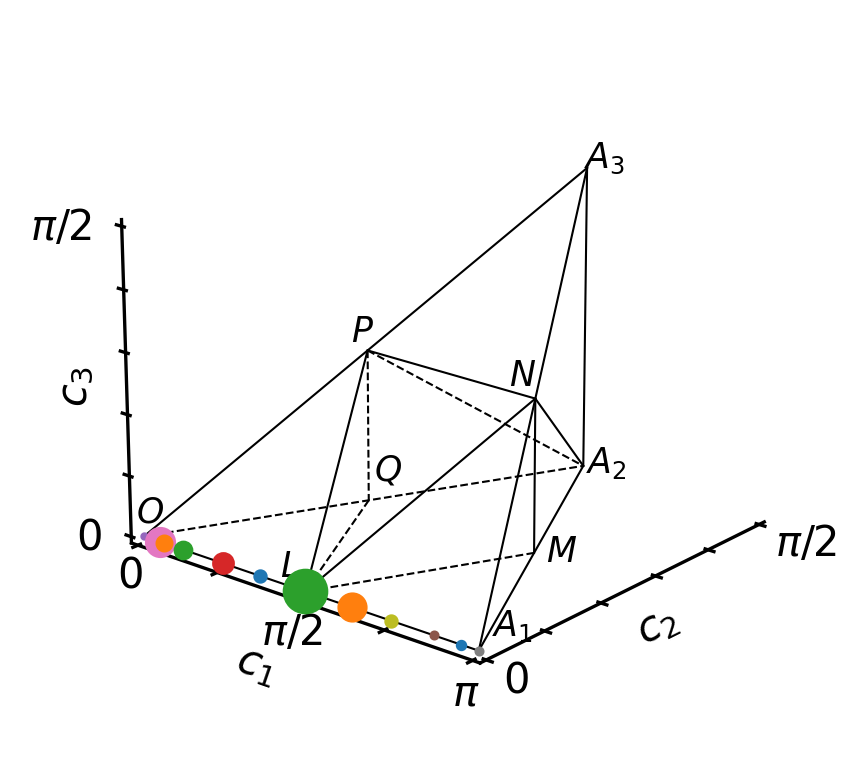

In [59]:
w = weylchamber.WeylChamber()
for k, v in coordinate_freq.items():
    w.scatter(*k, s=v)
w.plot()